<a href="https://colab.research.google.com/github/albreyes/PE-A-09/blob/main/vector_output_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Pronóstico univariado a multiples pasos usando LSTM 

En este ejercicio aprenderemos a utilizar python para crear un modelo de pronóstico para una serie de datos de demanda eléctrica anual. La entrada será una serie de tres pasos. El pronóstico tendrá dos pasos en adelanto y los resultados se presentarán paso por paso. El paso de tiempo (timestep) tanto en la entrada como en la salida será de un año. Como técnica de aprendizaje utilizaremos una red LSTM apilada (stacked)



## Preparación de los datos

Antes de pasar a la construcción del modelo se deben preparar los datos. Al igual que con el pronóstico de un paso, una serie de tiempo utilizada para el pronóstico de series de varios pasos debe dividirse en muestras con componentes de entrada y salida.

Tanto los componentes de entrada como los de salida estarán compuestos por múltiples pasos de tiempo y pueden tener o no el mismo número de pasos.

Por ejemplo, dada la serie de tiempo univariada:

\\begin{matrix}[10 & 20 & 30 & 40 & 50 & 60 & 70 & 80 & 90 ]\\\end{matrix}

Podríamos usar los últimos tres pasos de tiempo como entrada y pronosticar los dos próximos pasos de tiempo.

La primera muestra se vería de la siguiente manera:

Entrada:

\\begin{matrix}[10 & 20 & 30 ]\\\end{matrix}

Salida:


\\begin{matrix}[40 & 50 ]\\\end{matrix}

La función split_sequence() siguiente implementa este comportamiento dividiendo una serie de tiempo univariada en muestras con un número específico de pasos de tiempo de entrada y salida.

In [74]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

Podemos demostrar esta función con el conjunto de datos de ejemplo.

In [75]:
# definimos secuancia de entrada 
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# escogemos un número de pasos de entrada y salida 
n_steps_in, n_steps_out = 3, 2
# dividimos en ejemplos X , y
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# visualizamos los resultados
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


La ejecución del ejemplo divide la serie univariada  en pasos de tiempo de entrada y salida e imprime los componentes de entrada y salida de cada uno.

Ahora que sabemos cómo preparar datos para el pronóstico de varios pasos, veamos como construir una red LSTM tipo output vector model.

Al igual que otros tipos de modelos de redes neuronales, el LSTM puede generar un vector directamente que se puede interpretar como un pronóstico de varios pasos.

Al igual que con los LSTM para datos univariados de la sección anterior, primero se deben remodelar (reshape) las muestras preparadas. El LSTM espera que los datos tengan una estructura tridimensional de la forma: [***muestras, intervalos de tiempo, características***] y, como en este caso solo tenemos una característica,  la remodelación es muy sencilla. Veamos como cambia el formato para el conjunto de entradas:

In [76]:
print('Antes',X)
# remodela de [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print('Después',X)

Antes [[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]]
Después [[[10]
  [20]
  [30]]

 [[20]
  [30]
  [40]]

 [[30]
  [40]
  [50]]

 [[40]
  [50]
  [60]]

 [[50]
  [60]
  [70]]]


Ahora si, usemos un conjunto de datos de [demanda eléctrica en Australia](https://www.kaggle.com/dcervan/demanda-electrica-australia) con datos promedio anual durante 16 años para realizar un pronóstico a un horizonte de dos años, en pasos de un año. Utilizaremos los mismo datos de la sección anterior pero en formato anual. Primero, carguemos los datos desde drive y visualicemos:

In [77]:
# montamos la unidad de drive en colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [78]:
import csv
import numpy as np

data_path= 'gdrive/My Drive/INEEL/cemie redes/PE-A-09/datasets/Demanda_electricidad_anual-sinFecha.csv'
#data_path= 'gdrive/My Drive/INEEL/cemie redes/PE-A-09/datasets/Demanda_electricidad_mensual-2-sinFecha.csv'

with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    raw_seq = np.array(list(reader)).astype(float)
    raw_seq = [row[0] for row in raw_seq]

print(raw_seq)

[8161.0, 8600.0, 8813.0, 8996.0, 9660.0, 10149.0, 10583.0, 11143.0, 11694.0, 12422.0, 12940.0, 12975.0, 13134.0, 13514.0, 13548.0, 13958.0]


Text(0, 0.5, 'Demanda (GW-h)')

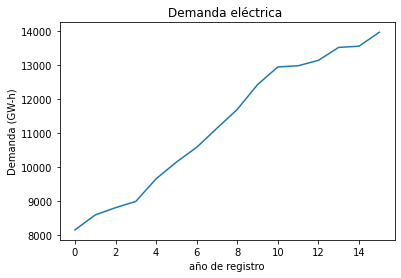

In [79]:
import matplotlib.pyplot as plt

plt.title('Demanda eléctrica ')
plt.plot(raw_seq)
plt.xlabel('año de registro')
plt.ylabel('Demanda (GW-h)')

Con el número de pasos de entrada y salida especificados en las variables *n_steps_in* y *n_steps_out*, podemos definir un modelo de pronóstico de series de tiempo de varios pasos.

Se puede utilizar cuaquier topolgía de modelo LSTM, como Vanilla, Stacked, Bidirectional, CNN-LSTM o ConvLSTM. A continuación se define un LSTM apilado (stacked) para el pronóstico a  varios pasos.

En cada celda LSTM se define su tipo de activación, optimizador y función de pérdida (generalmente MSE) para cáculo del error.

In [80]:

# escoger el número de pasos de timpo (time steps)
n_steps_in, n_steps_out = 3, 2
# separar en muestras (preparación)
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# remodelación del formato [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# definición del modelo
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1050, verbose=0)


Mostramos en forma de tabla y con una imágen información de la red LSTM construida.

In [81]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 3, 100)            40800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 121,402
Trainable params: 121,402
Non-trainable params: 0
_________________________________________________________________


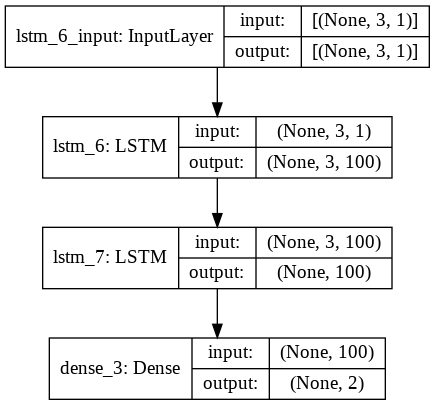

In [82]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='gdrive/My Drive/INEEL/Cubico/grupo_pronostico/datos/model_plot-output-vector.png', show_shapes=True, show_layer_names=True)

Y hacemos una demostracón de la predicción. Aquí seleccionamos aleatorimanente un vector de entrada, calculamos su pronóstico y lo comparamos con el vector de salida real (conocido). Para facilitar la lectura, graficamos la salida real contra la pronosticada (línea punteada verde).

secuencia de entrada: [8600. 8813. 8996.]
secuencia de salida (predicha): [9483.084 9796.098]
secuencia de salida (real): [ 9660. 10149.]


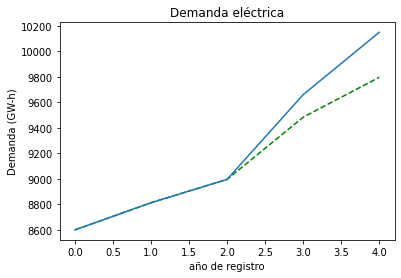

In [83]:
# demonstrate prediction
l=X.reshape((X.shape[0],X.shape[1]))
i_sample = np.random.randint(len(y))   # Tomar un ejemplo aleatorio
x_sample = l[i_sample]
x_sample = x_sample.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_sample, verbose=0)
print('secuencia de entrada:',l[i_sample])
print('secuencia de salida (predicha):',yhat[0])
print('secuencia de salida (real):',y[i_sample])

trama_real=np.append(l[i_sample],y[i_sample])
trama_predicha=np.append(l[i_sample],yhat[0])
plt.title('Demanda eléctrica')
plt.xlabel('año de registro')
plt.ylabel('Demanda (GW-h)')
plt.plot(trama_predicha,color='green', linestyle='dashed')
plt.plot(trama_real)

Guardamos todos los vectores de salida pronosticados para posteriormente compararlos con los vectores de salida reales.

In [84]:
import numpy as np

l=X.reshape((X.shape[0],X.shape[1]))
lista_tplus1=array([])
lista_tplus2=array([])
lista_tplusn=array([])
for i in l:
    i = i.reshape((1, n_steps_in, n_features))
    yhat = model.predict(i, verbose=0)
    lista_tplus1=np.append(lista_tplus1,yhat[0][0])
    lista_tplus2=np.append(lista_tplus2,yhat[0][1])

print('pronostico en t+1:',lista_tplus1)
print('pronostico en t+2:',lista_tplus2)

pronostico en t+1: [ 9108.98632812  9483.08398438  9768.96679688 10155.75097656
 10793.77636719 11319.48535156 11846.234375   12476.63964844
 13125.14746094 13757.59863281 14125.9375     14249.58398438]
pronostico en t+2: [ 9408.61425781  9796.09765625 10087.17480469 10486.96386719
 11147.22167969 11689.41503906 12233.37207031 12883.13671875
 13554.58300781 14213.09667969 14593.99609375 14719.36035156]


Mostramos gráficamente el pronóstico en el paso t+1 (línea azul) vs el valor real en el paso t+1 (línea naranja)

Text(0, 0.5, 'Demanda (GW-h)')

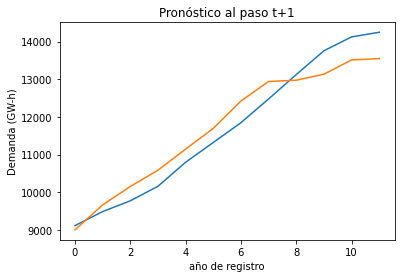

In [85]:
plt.title('Pronóstico al paso t+1')
plt.plot(lista_tplus1)
plt.plot(y[:,0])
plt.xlabel('año de registro')
plt.ylabel('Demanda (GW-h)')

Y el pronóstico en el paso t+2 (línea azul) vs el valor real en el paso t+2 (línea naranja)

Text(0, 0.5, 'Demanda (GW-h)')

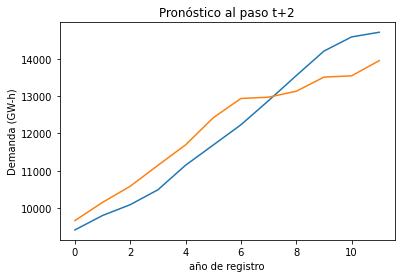

In [86]:
plt.title('Pronóstico al paso t+2')
plt.plot(lista_tplus2)
plt.plot(y[:,1])
plt.xlabel('año de registro')
plt.ylabel('Demanda (GW-h)')

Definimos una función simple para calcular el MAPE

In [87]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Finalmente, evaluamos nuestro modelo calculando el error MAPE para cada paso del pronóstico *(t+1, t+2)* que no esta nada mal.



In [88]:
mape1=mean_absolute_percentage_error(lista_tplus1, y[:,0])
mape2=mean_absolute_percentage_error(lista_tplus2, y[:,1])
print('MAPE tiempo t+1:',mape1)
print('MAPE tiempo t+2:',mape2)

#for x in range(n_steps_out):
#  print(x)
#lista_tplusN=array([])
#lista_tplusN[0]=

MAPE tiempo t+1: 3.4377985744200834
MAPE tiempo t+2: 4.6223568395924675


Nota: Dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, los resultados o las diferencias en la precisión numérica pueden variar. Considere ejecutar el ejemplo varias veces y compare el resultado promedio.